# Load cleaned data and preprocessing data here

In [8]:
import pandas as pd

# # Load the CSV file into a DataFrame
# df = pd.read_csv("cleaned_human_face_emotions.csv")

# Load the Parquet file (instead)
df = pd.read_parquet("cleaned_human_face_emotions.parquet")

# Drop a column (for example, the "qa" column)
df = df.drop(columns=["qa"])

# Print the first few rows of the updated DataFrame
print(df.head())

                                               image  emotion
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      sad
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    anger
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  neutral
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...     fear
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  content


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    9400 non-null   object
 1   emotion  9400 non-null   object
dtypes: object(2)
memory usage: 147.0+ KB


Now we just have images in the first column with the emotion in the second column.

In [10]:
from sklearn.model_selection import train_test_split

# Separate feature (X) and label (y)
X = df['image']
y = df['emotion']

# Perform a stratified split to keep class distribution consistent
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 80% training, 20% testing
    random_state=42,    # for reproducibility
    stratify=y          # important for classification
)

# Validation split from X_train if needed:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,     # 25% of the training set (which is 20% of the total) -> 15% overall
    random_state=42,
    stratify=y_train
)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
print("Validation set size:", len(X_val))

Training set size: 5640
Test set size: 1880
Validation set size: 1880


In [11]:
import io
import numpy as np
from PIL import Image

# Image bytes -> numpy arrays
def decode_images(image_series, target_size=(224, 224)):
    """
    Takes a pandas Series of dictionaries, each containing {'bytes': ...}.
    Decodes them into a list of NumPy arrays (RGB).
    Resizes images to target_size.
    Normalizes pixel values to [0, 1].

    Returns:
      - A NumPy array of shape (num_samples, target_size[0], target_size[1], 3)
    """
    decoded_list = []
    for item in image_series:
        # item should be a dict like {'bytes': b'...'}
        try:
            img_bytes = item['bytes']
            with Image.open(io.BytesIO(img_bytes)) as img:
                # Convert to RGB if needed
                img = img.convert('RGB')
                # Resize
                img = img.resize(target_size)
                # Convert to array
                arr = np.array(img, dtype=np.float32) / 255.0
            decoded_list.append(arr)
        except Exception as e:
            # If there's a bad image, you might want to handle or skip it
            print("Error decoding image:", e)
            # Optionally skip or handle it somehow. For now, let's skip:
            # Continue with the loop
            continue

    return np.stack(decoded_list, axis=0)

print("\nDecoding and resizing images...")

# Decode train set
X_train_array = decode_images(X_train, target_size=(224, 224))
print("X_train_array shape:", X_train_array.shape)

# Decode val set
X_val_array = decode_images(X_val, target_size=(224, 224))
print("X_val_array shape:", X_val_array.shape)

# Decode test set
X_test_array = decode_images(X_test, target_size=(224, 224))
print("X_test_array shape:",  X_test_array.shape)


Decoding and resizing images...
X_train_array shape: (5640, 224, 224, 3)
X_val_array shape: (1880, 224, 224, 3)
X_test_array shape: (1880, 224, 224, 3)


In [12]:
# Encode labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded   = label_encoder.transform(y_val)
y_test_encoded  = label_encoder.transform(y_test)

print("\nLabel classes found:", label_encoder.classes_)
print("Sample of encoded labels:", y_train_encoded[:10])


Label classes found: ['anger' 'content' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Sample of encoded labels: [6 3 5 6 0 6 7 3 4 0]


# Use transfer learning with pre-trained CNN model
convert the existing pipeline to use a pre-trained network such as ResNet50 in a transfer‐learning setup for multi-class classification using cross-entropy loss. In a transfer-learning approach, it typically replace the top (classification) layers of the pre-trained network with our own custom head and use a loss such as categorical cross-entropy (or sparse categorical cross-entropy if your labels remain as integers). We then train the added head first, and optionally fine-tune the deeper layers later.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,718,792 (56.15 MB)

 Trainable params: 4,104 (16.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 49s 275ms/step - accuracy: 0.1264 - loss: 2.3619 - val_accuracy: 0.2176 - val_loss: 2.0373
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 47s 265ms/step - accuracy: 0.1715 - loss: 2.0640 - val_accuracy: 0.2319 - val_loss: 1.9883
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 47s 264ms/step - accuracy: 0.1974 - loss: 2.0143 - val_accuracy: 0.2963 - val_loss: 1.9481
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 47s 264ms/step - accuracy: 0.2196 - loss: 1.9839 - val_accuracy: 0.2968 - val_loss: 1.9219
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 47s 266ms/step - accuracy: 0.2329 - loss: 1.9590 - val_accuracy: 0.2915 - val_loss: 1.9063
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 47s 265ms/step - accuracy: 0.2451 - loss: 1.9437 - val_accuracy: 0.3261 - val_loss: 1.8870
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 47s 264ms/step - accuracy: 0.2626 - loss: 1.9256 - val_accuracy: 0.3293 - val_loss: 1.8726
Epoch 8/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 47s 264ms/step - accuracy: 0.2655 - loss: 1


Test Loss: 1.7858
Test Accuracy: 0.3580
Model saved as VGG16_basemodel.h5
Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 51s 282ms/step - accuracy: 0.2983 - loss: 1.8310 - val_accuracy: 0.3707 - val_loss: 1.7465
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 48s 273ms/step - accuracy: 0.3127 - loss: 1.8080 - val_accuracy: 0.3670 - val_loss: 1.7316
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 48s 273ms/step - accuracy: 0.3242 - loss: 1.7820 - val_accuracy: 0.3723 - val_loss: 1.7053
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 48s 273ms/step - accuracy: 0.3338 - loss: 1.7728 - val_accuracy: 0.3787 - val_loss: 1.6907
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 48s 273ms/step - accuracy: 0.3529 - loss: 1.7405 - val_accuracy: 0.3862 - val_loss: 1.6777
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 48s 274ms/step - accuracy: 0.3368 - loss: 1.7531 - val_accuracy: 0.3835 - val_loss: 1.6662
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 49s 277ms/step - accuracy: 0.3461 - loss: 1.7421 - val_accuracy: 0.3856 - val_loss: 1.6554
Epoch 8/


Final Test Loss after fine-tuning: 1.5712
Final Test Accuracy after fine-tuning: 0.4101
Fine-tuned model saved as VGG16_basemodel_finetuned.h5


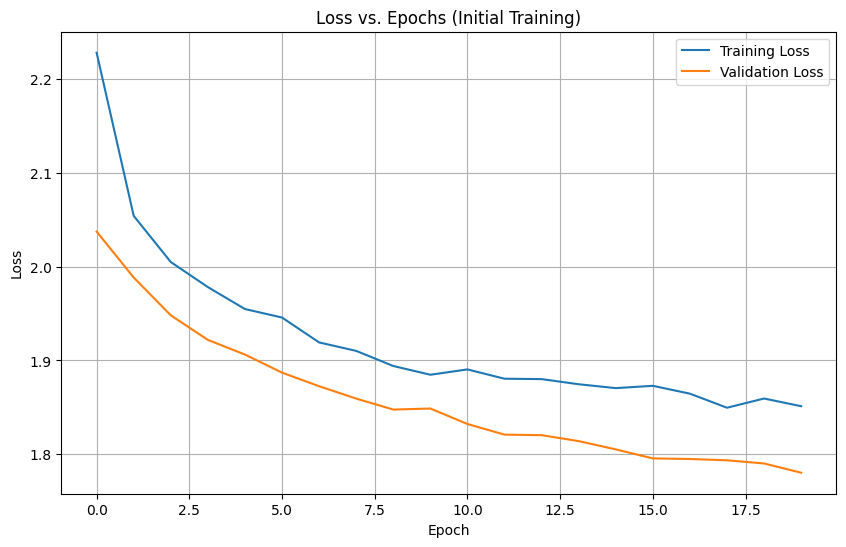

59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step

Confusion Matrix:
[[ 84  27  36  10  11  23  25  19]
 [ 22 107  14   5  22  30  11  18]
 [ 40  26  64  10  37  14  23  19]
 [ 15   5  20 105   2   8  14  67]
 [  6  24  15   3 145   7   6  12]
 [ 21  35  13   7  15  91  15  48]
 [ 45  17  40  14  14  37  46  24]
 [ 23  11   8  30   8  29   9 129]]


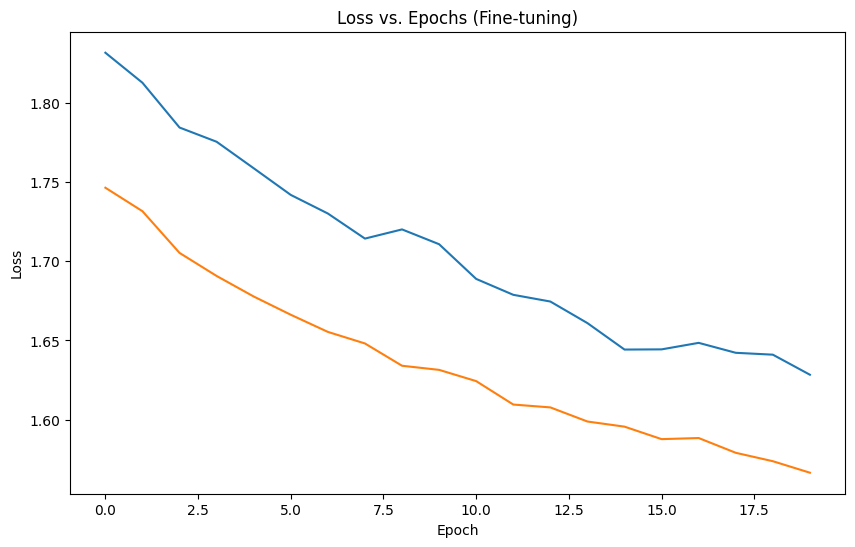

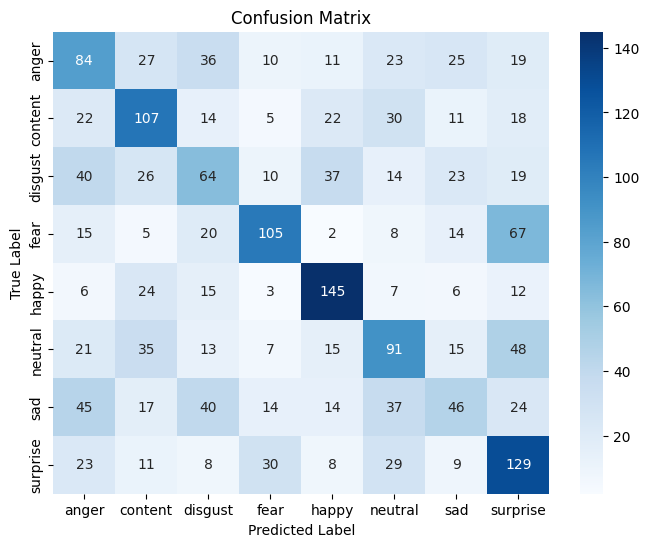


Classification Report:
              precision    recall  f1-score   support

       anger       0.33      0.36      0.34       235
     content       0.42      0.47      0.44       229
     disgust       0.30      0.27      0.29       233
        fear       0.57      0.44      0.50       236
       happy       0.57      0.67      0.61       218
     neutral       0.38      0.37      0.38       245
         sad       0.31      0.19      0.24       237
    surprise       0.38      0.52      0.44       247

    accuracy                           0.41      1880
   macro avg       0.41      0.41      0.41      1880
weighted avg       0.41      0.41      0.40      1880



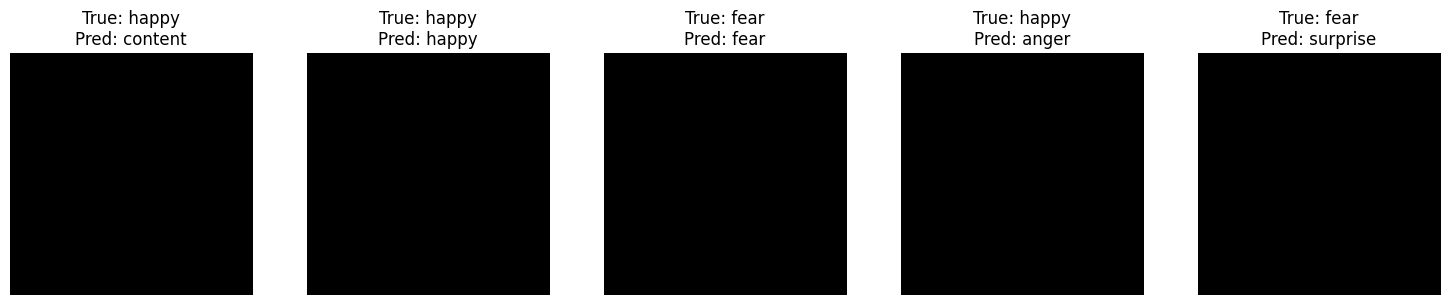

/var/folders/0x/xc2w9g656bdcnpb7s0m1zhyw0000gn/T/ipykernel_42411/103334642.py:157: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


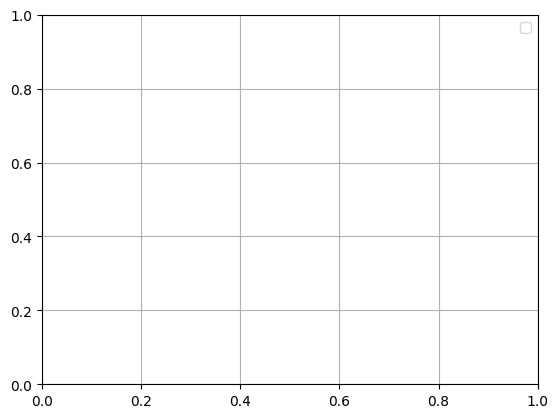

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Again assume: X_train_array, X_val_array, X_test_array, and y_train_encoded, y_val_encoded, y_test_encoded.
# And num_classes is defined.
num_classes = len(label_encoder.classes_)

# Define a data augmentation pipeline.
data_augmentation = tf.keras.Sequential([
    # Randomly rotate images up to 25% (roughly ±90° when set to 0.25, or adjust as needed).
    layers.RandomRotation(0.25),
    # Randomly flip images horizontally.
    layers.RandomFlip("horizontal")
])

# Use VGG16 as the base pre-trained model.
base_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model initially.
base_model.trainable = False

# Build the model.
model = models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    # Data augmentation layers (active only during training).
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # VGG16 sometimes benefits from a higher dropout.
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model with sparse categorical cross entropy loss.
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# Train the classifier head.
history = model.fit(
    X_train_array, y_train_encoded,
    validation_data=(X_val_array, y_val_encoded),
    epochs=20,
    batch_size=32
)

# Evaluate on test data.
test_loss, test_acc = model.evaluate(X_test_array, y_test_encoded)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Save the trained model (HDF5 format).
model.save("VGG16_basemodel.h5")
print("Model saved as VGG16_basemodel.h5")

# Fine-tuning:
# Unfreeze all first
base_model.trainable = True

# Freeze all layers except the last two.
for layer in base_model.layers[:-2]:
    layer.trainable = False


model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=['accuracy']
)

history_fine = model.fit(
    X_train_array, y_train_encoded,
    validation_data=(X_val_array, y_val_encoded),
    epochs=20,
    batch_size=32
)

final_loss, final_acc = model.evaluate(X_test_array, y_test_encoded)
print(f"\nFinal Test Loss after fine-tuning: {final_loss:.4f}")
print(f"Final Test Accuracy after fine-tuning: {final_acc:.4f}")

# save the fine-tuned model
model.save("VGG16_basemodel_finetuned.h5")
print("Fine-tuned model saved as VGG16_basemodel_finetuned.h5")

# Plot loss versus epochs (for initial training).
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss vs. Epochs (Initial Training)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# If you want to also plot the fine-tuning phase's loss,
# you can do something similar:
plt.figure(figsize=(10, 6))
plt.plot(history_fine.history['loss'], label='Fine-tune Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tune Validation Loss')
plt.title("Loss vs. Epochs (Fine-tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# ------------------------- Quantitative & Qualitative Analysis -------------------------
# Generate predictions on the test set. Note: using np.argmax to get the predicted class.
y_pred_probs = model.predict(X_test_array)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate the confusion matrix.
cm = confusion_matrix(y_test_encoded, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix using a heatmap.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print the classification report.
report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_)
print("\nClassification Report:")
print(report)

# For qualitative analysis, you might want to see some sample predictions.
# Let's display a few test images along with their predicted and true labels.
num_samples = 5  # number of samples to display
indices = np.random.choice(np.arange(len(X_test_array)), num_samples, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(X_test_array[idx].astype('uint8'))
    true_label = label_encoder.classes_[y_test_encoded[idx]]
    pred_label = label_encoder.classes_[y_pred[idx]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()
plt.legend()
plt.grid(True)
plt.show()

Model loaded from VGG16_basemodel_finetuned.h5

Test Loss: 1.5712
Test Accuracy: 0.4101
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step

Confusion Matrix:
[[ 84  27  36  10  11  23  25  19]
 [ 22 107  14   5  22  30  11  18]
 [ 40  26  64  10  37  14  23  19]
 [ 15   5  20 105   2   8  14  67]
 [  6  24  15   3 145   7   6  12]
 [ 21  35  13   7  15  91  15  48]
 [ 45  17  40  14  14  37  46  24]
 [ 23  11   8  30   8  29   9 129]]


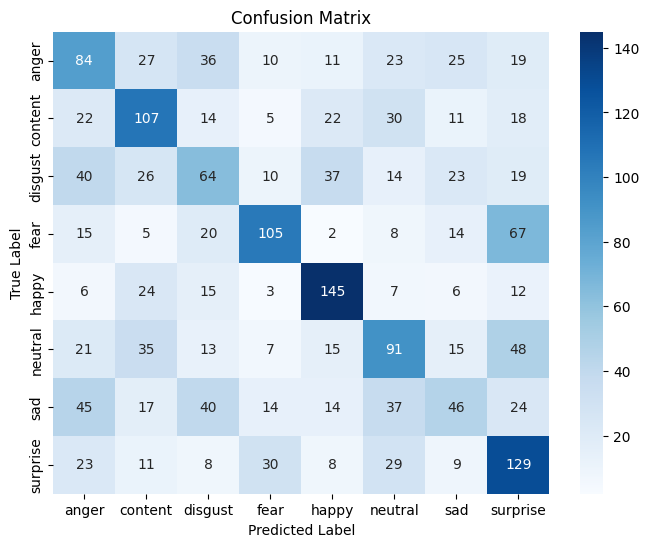


Classification Report:
              precision    recall  f1-score   support

       anger       0.33      0.36      0.34       235
     content       0.42      0.47      0.44       229
     disgust       0.30      0.27      0.29       233
        fear       0.57      0.44      0.50       236
       happy       0.57      0.67      0.61       218
     neutral       0.38      0.37      0.38       245
         sad       0.31      0.19      0.24       237
    surprise       0.38      0.52      0.44       247

    accuracy                           0.41      1880
   macro avg       0.41      0.41      0.41      1880
weighted avg       0.41      0.41      0.40      1880



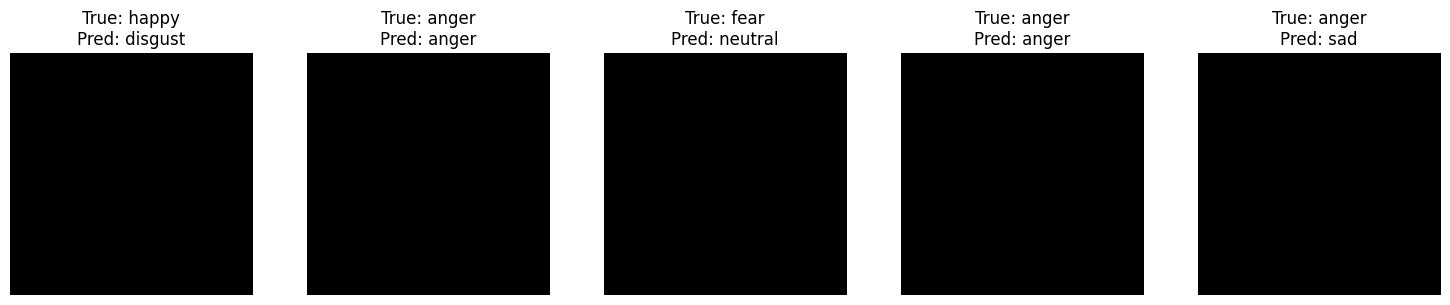

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# ---------------------- LOAD THE MODEL ----------------------
# Load the previously saved model. Change the filename as needed.
model_path = "VGG16_basemodel_finetuned.h5"
model = load_model(model_path)
print(f"Model loaded from {model_path}")

# ---------------------- MODEL EVALUATION ----------------------
# Evaluate the model on the test data.
test_loss, test_acc = model.evaluate(X_test_array, y_test_encoded, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# ------------------------ PREDICTIONS ------------------------
# Generate prediction probabilities on the test set and convert these to class labels.
y_pred_probs = model.predict(X_test_array)
y_pred = np.argmax(y_pred_probs, axis=1)

# ------------------ CONFUSION MATRIX AND HEATMAP ------------------
cm = confusion_matrix(y_test_encoded, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_ if 'label_encoder' in globals() else label_classes,
            yticklabels=label_encoder.classes_ if 'label_encoder' in globals() else label_classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ------------------ CLASSIFICATION REPORT ------------------
report = classification_report(
    y_test_encoded,
    y_pred,
    target_names=label_encoder.classes_ if 'label_encoder' in globals() else label_classes
)
print("\nClassification Report:")
print(report)

# ------------------ QUALITATIVE ANALYSIS ------------------
# Display a few random test images with their true and predicted labels.
num_samples = 5  
# Select random indices from the test set.
indices = np.random.choice(np.arange(len(X_test_array)), num_samples, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(X_test_array[idx].astype('uint8'))
    true_label = label_encoder.classes_[y_test_encoded[idx]] if 'label_encoder' in globals() else label_classes[y_test_encoded[idx]]
    pred_label = label_encoder.classes_[y_pred[idx]] if 'label_encoder' in globals() else label_classes[y_pred[idx]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

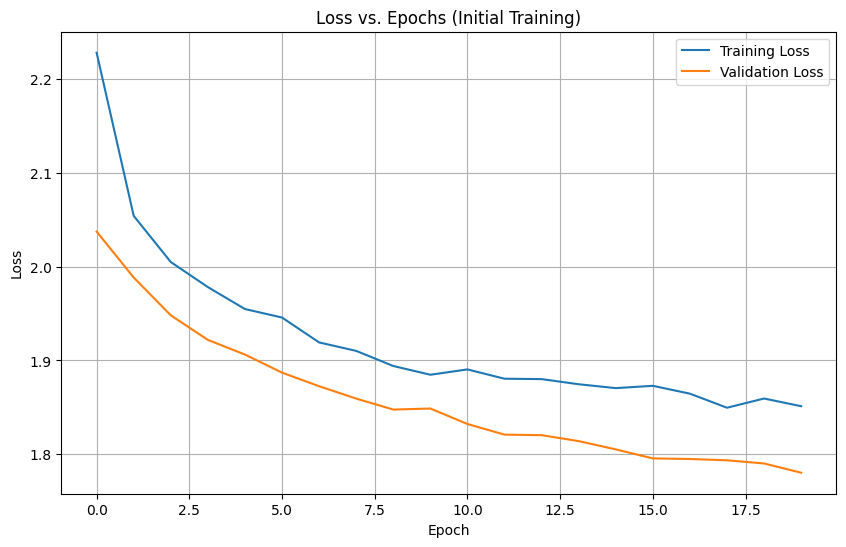

In [15]:
# Plot loss versus epochs (for initial training).
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss vs. Epochs (Initial Training)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Text(0, 0.5, 'Loss')

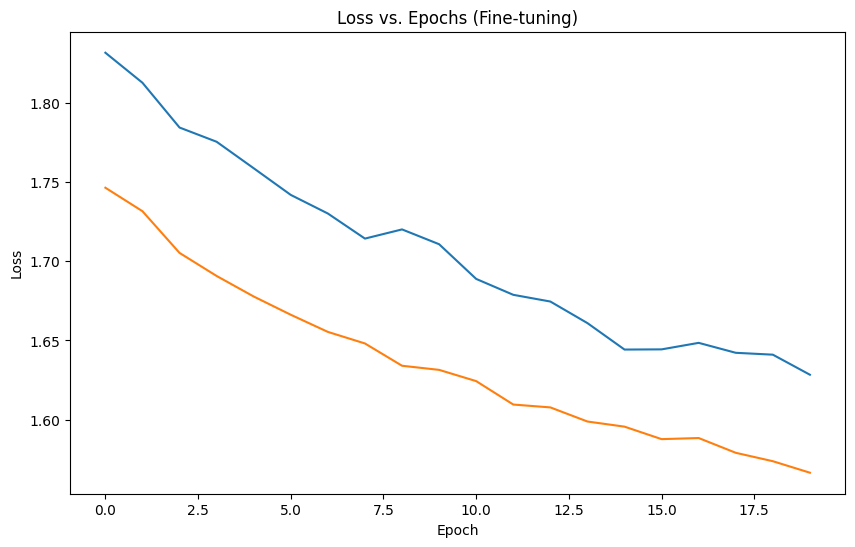

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(history_fine.history['loss'], label='Fine-tune Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tune Validation Loss')
plt.title("Loss vs. Epochs (Fine-tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step

Confusion Matrix:
[[ 84  27  36  10  11  23  25  19]
 [ 22 107  14   5  22  30  11  18]
 [ 40  26  64  10  37  14  23  19]
 [ 15   5  20 105   2   8  14  67]
 [  6  24  15   3 145   7   6  12]
 [ 21  35  13   7  15  91  15  48]
 [ 45  17  40  14  14  37  46  24]
 [ 23  11   8  30   8  29   9 129]]


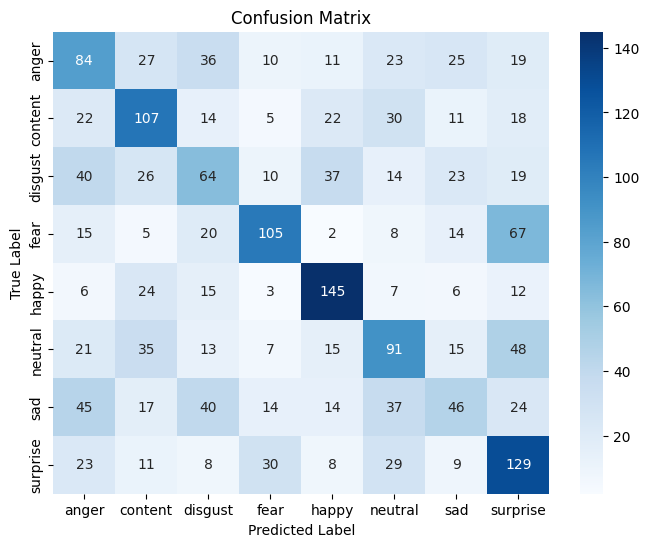


Classification Report:
              precision    recall  f1-score   support

       anger       0.33      0.36      0.34       235
     content       0.42      0.47      0.44       229
     disgust       0.30      0.27      0.29       233
        fear       0.57      0.44      0.50       236
       happy       0.57      0.67      0.61       218
     neutral       0.38      0.37      0.38       245
         sad       0.31      0.19      0.24       237
    surprise       0.38      0.52      0.44       247

    accuracy                           0.41      1880
   macro avg       0.41      0.41      0.41      1880
weighted avg       0.41      0.41      0.40      1880



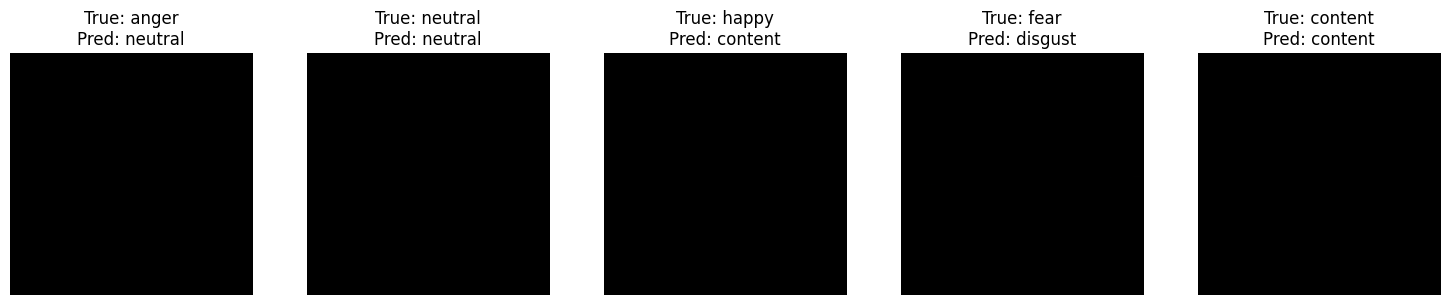

/var/folders/0x/xc2w9g656bdcnpb7s0m1zhyw0000gn/T/ipykernel_42411/2690342690.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


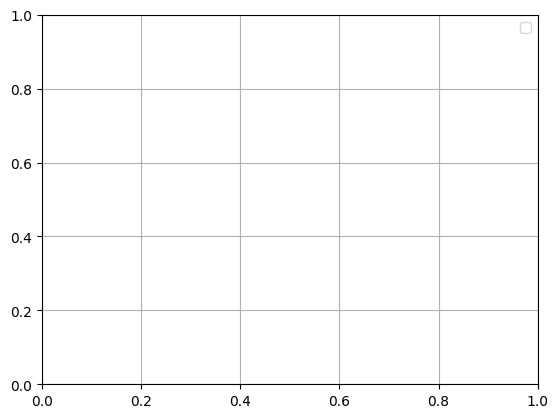

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# ------------------------- Quantitative & Qualitative Analysis -------------------------
# Generate predictions on the test set. Note: using np.argmax to get the predicted class.
y_pred_probs = model.predict(X_test_array)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate the confusion matrix.
cm = confusion_matrix(y_test_encoded, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix using a heatmap.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print the classification report.
report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_)
print("\nClassification Report:")
print(report)

# For qualitative analysis, you might want to see some sample predictions.
# Let's display a few test images along with their predicted and true labels.
num_samples = 5  # number of samples to display
indices = np.random.choice(np.arange(len(X_test_array)), num_samples, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(X_test_array[idx].astype('uint8'))
    true_label = label_encoder.classes_[y_test_encoded[idx]]
    pred_label = label_encoder.classes_[y_pred[idx]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()
plt.legend()
plt.grid(True)
plt.show()